# Simple Armed-Bandit Learning Algorithms

By: Isaac Edem Adoboe - [ieadoboe - GitHub](https://github.com/ieadoboe)


Goal: Compare performance in terms of

1. the average per-step reward and
2. the proportion of time the optimal action (highest expected reward)


In [1]:
# import necessary libraries
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit, vmap

import numpy as np
import matplotlib.pyplot as plt

#### Setup


In [2]:
# set random number generator for reproducibility
key = random.PRNGKey(123)

#### True Means vs Rewards

The true means in reality are hidden and cannot be directly observed.


In [9]:
# Create bandit environment - k-armed bandit means from N(0,1)
def create_bandit_testbed(key, k=10):
    return random.normal(key, (k,))


# True means
true_means = create_bandit_testbed(key=key)
print(f"True means (aka ground truth):\n {true_means}")

True means (aka ground truth):
 [-0.10502207 -0.56205004 -0.56485987 -1.7063935   0.56626016 -0.42215332
  1.0077653   0.9922631  -0.61236995 -1.8450408 ]


In this problem, we assume they never change hence we use this true means for all 2000 time steps.


In [25]:
# Define the reward function from N(mu, 1)
def get_reward(key, arm, true_means):
    return random.normal(key) + true_means[arm]


# test the reward function
rewards = get_reward(key, 4, true_means)
print(f"Reward from pulling arm 4: {rewards}")

Reward from pulling arm 4: -0.18681830167770386


# Testing different algorithms


### Greedy with non-optimistic initial values


In [26]:
# Greedy with non-optimistic initial values
def greedy_bandit(key, true_means, n_steps=2000):
    k = len(true_means)

    # Initialize Q values with non-optimistic initial values (zeros)
    Q = jnp.zeros(k)
    action_counts = jnp.zeros(k)

    # Initialize rewards
    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Find the optimal arm (highest mean)
    optimal_arm = jnp.argmax(true_means)

    for step in range(n_steps):
        key, subkey = random.split(key)  # for arm selection

        # Find arms with the highest Q value
        max_q = jnp.max(Q)
        best_arms = jnp.where(Q == max_q)[0]

        # Random tie-breaker among best arms
        chosen_arm = random.choice(subkey, best_arms)

        # Get reward for chosen arm
        key, subkey = random.split(key)  # for reward generation
        reward = random.normal(subkey) + true_means[chosen_arm]

        # Update Q value for chosen arm
        action_counts = action_counts.at[chosen_arm].add(1)
        n = action_counts[chosen_arm]

        Q = Q.at[chosen_arm].add((reward - Q[chosen_arm]) / n)

        # update results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q, action_counts

In [33]:
def plot_performance_vs_optimal(rewards, optimal_actions, true_means, window_size=50):
    """
    Plot algorithm performance vs optimal performance over time
    """
    n_steps = len(rewards)
    optimal_reward = jnp.max(true_means)  # Best possible reward per step

    # Calculate moving averages
    def moving_average(data, window):
        return jnp.convolve(data, jnp.ones(window) / window, mode="valid")

    # Cumulative average reward
    cumulative_avg_reward = jnp.cumsum(rewards) / jnp.arange(1, n_steps + 1)

    # Moving average reward
    moving_avg_reward = moving_average(rewards, window_size)

    # Moving average % optimal actions
    moving_optimal_pct = (
        moving_average(optimal_actions.astype(float), window_size) * 100
    )

    # Create the plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Cumulative Average Reward vs Optimal
    ax1.plot(cumulative_avg_reward, "b-", linewidth=2, label="Algorithm Performance")
    ax1.axhline(
        y=optimal_reward,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Optimal ({optimal_reward:.3f})",
    )
    ax1.fill_between(
        range(n_steps),
        cumulative_avg_reward,
        optimal_reward,
        alpha=0.3,
        color="red",
        label="Performance Gap",
    )
    ax1.set_title("Cumulative Average Reward vs Optimal")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Average Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Moving Average Reward vs Optimal
    steps_ma = range(window_size - 1, n_steps)
    ax2.plot(
        steps_ma,
        moving_avg_reward,
        "b-",
        linewidth=2,
        label=f"Algorithm ({window_size}-step avg)",
    )
    ax2.axhline(
        y=optimal_reward,
        color="r",
        linestyle="--",
        linewidth=2,
        label=f"Optimal ({optimal_reward:.3f})",
    )
    ax2.fill_between(
        steps_ma,
        moving_avg_reward,
        optimal_reward,
        alpha=0.3,
        color="red",
        label="Performance Gap",
    )
    ax2.set_title(f"Moving Average Reward ({window_size} steps) vs Optimal")
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Average Reward")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Percentage of Optimal Actions Over Time
    ax3.plot(
        steps_ma,
        moving_optimal_pct,
        "g-",
        linewidth=2,
        label=f"% Optimal Actions ({window_size}-step avg)",
    )
    ax3.axhline(y=100, color="r", linestyle="--", linewidth=2, label="Perfect (100%)")
    ax3.fill_between(
        steps_ma,
        moving_optimal_pct,
        100,
        alpha=0.3,
        color="red",
        label="Optimality Gap",
    )
    ax3.set_title("Percentage of Optimal Actions Over Time")
    ax3.set_xlabel("Time Step")
    ax3.set_ylabel("% Optimal Actions")
    ax3.set_ylim(0, 105)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Performance Gap Over Time
    performance_gap = optimal_reward - cumulative_avg_reward
    ax4.plot(performance_gap, "purple", linewidth=2, label="Cumulative Performance Gap")
    ax4.axhline(y=0, color="r", linestyle="--", linewidth=1, label="No Gap (Perfect)")
    ax4.fill_between(range(n_steps), performance_gap, 0, alpha=0.3, color="purple")
    ax4.set_title("Performance Gap (Optimal - Actual)")
    ax4.set_xlabel("Time Step")
    ax4.set_ylabel("Gap in Average Reward")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    final_performance = cumulative_avg_reward[-1]
    final_gap = optimal_reward - final_performance
    final_optimal_pct = jnp.mean(optimal_actions[-100:]) * 100  # Last 100 steps

    print(f"\n📊 PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Optimal reward per step:     {optimal_reward:.4f}")
    print(f"Algorithm's final avg:       {final_performance:.4f}")
    print(
        f"Performance gap:             {final_gap:.4f} ({final_gap/optimal_reward*100:.1f}%)"
    )
    print(f"Final optimality rate:       {final_optimal_pct:.1f}% (last 100 steps)")
    print(f"Total reward obtained:       {jnp.sum(rewards):.2f}")
    print(f"Total optimal reward:        {optimal_reward * n_steps:.2f}")
    print(
        f"Efficiency:                  {jnp.sum(rewards)/(optimal_reward * n_steps)*100:.1f}%"
    )

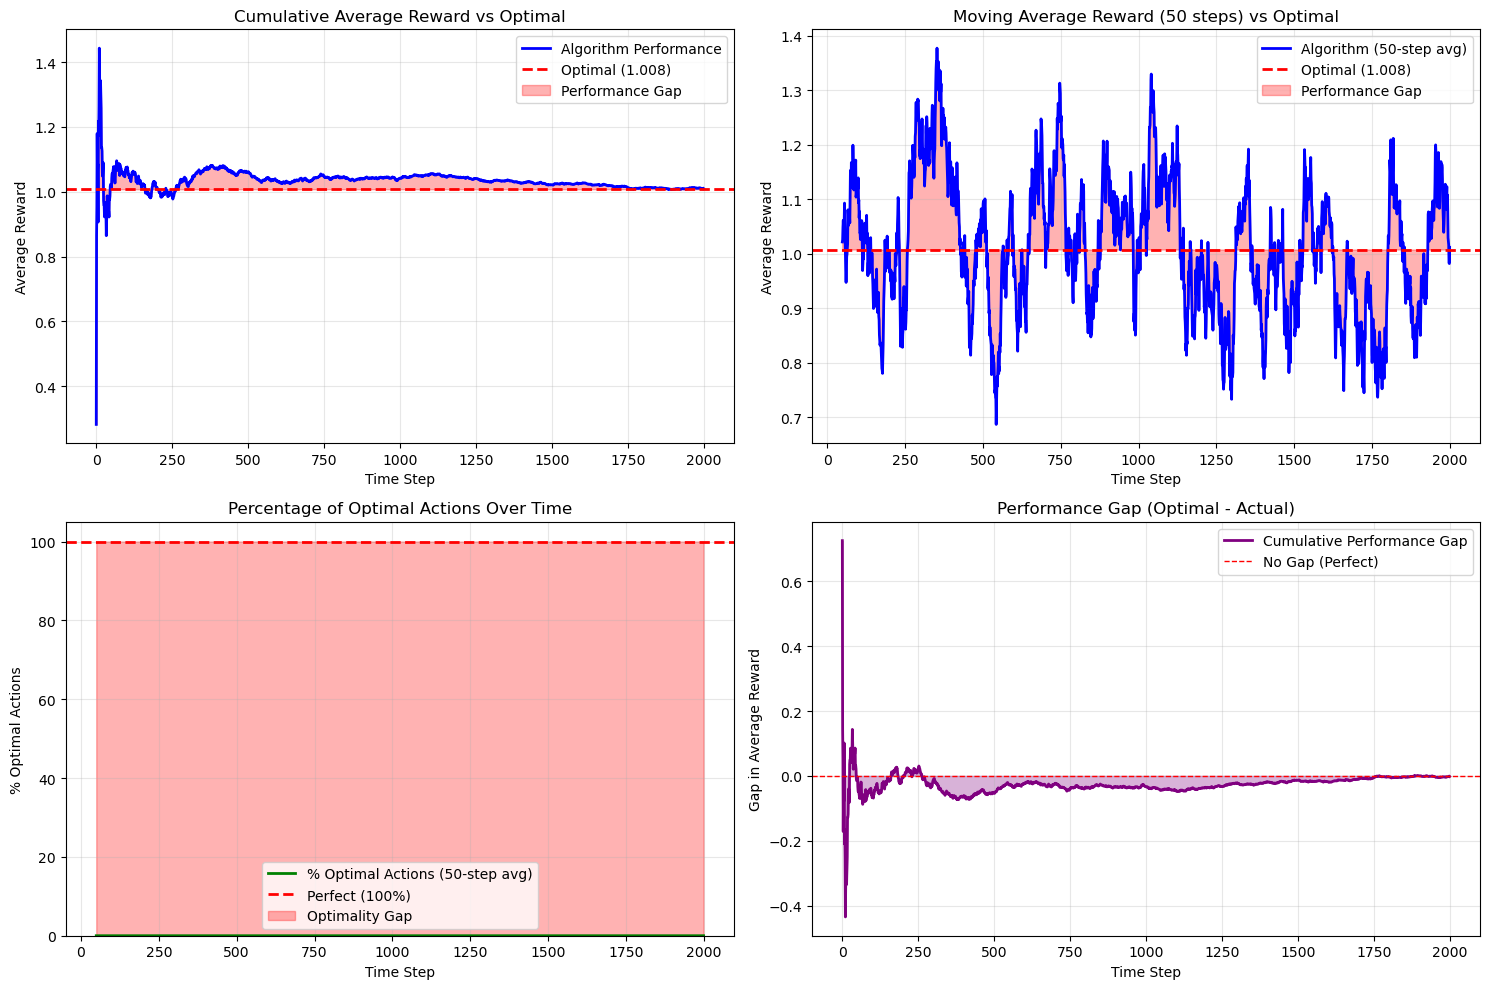


📊 PERFORMANCE SUMMARY
Optimal reward per step:     1.0078
Algorithm's final avg:       1.0097
Performance gap:             -0.0019 (-0.2%)
Final optimality rate:       0.0% (last 100 steps)
Total reward obtained:       2019.34
Total optimal reward:        2015.53
Efficiency:                  100.2%


In [34]:
rewards_1, optimal_actions_1, Q_1, counts_1 = greedy_bandit(key, true_means)

plot_performance_vs_optimal(rewards_1, optimal_actions_1, true_means)

In [ ]:
def epsilon_greedy_bandit(key, true_means, epsilon, n_steps=2000):
    # Implementation here
    pass

In [ ]:
def gradient_bandit(key, true_means, alpha, n_steps=2000):
    # Implementation here
    pass

In [ ]:
# Simulation runner
def run_simulation(key, algorithm_fn, true_means, **kwargs):
    # Track rewards and optimal actions
    pass

In [ ]:
# Main experiment
def run_experiment():
    # 1000 simulations for each algorithm
    # Compare performance
    pass